In [2]:
import tensorflow as tf
import apache_beam as beam
from typing import Dict, List, Tuple
import numpy as np

In [3]:
# # To achieve good shuffling, each label should be in its own file
# # The function will take one sample from each label (i.e. file) and then shuffle them
# def load_dataset(filenames: List[str], deserialization_function, number_of_files):
#     parallel_reads = len(filenames)
    
#     files = tf.data.Dataset.from_tensor_slices(filenames)

#     ds = files.interleave(lambda x: tf.data.TFRecordDataset(x), 
#                           cycle_length=len(filenames), 
#                           block_length=1,
#                           num_parallel_calls=tf.data.experimental.AUTOTUNE,
#                           deterministic=False)

#     ds = ds.flat_map(lambda x : deserialization_function(x, number_of_files))  # parse the record
#     ds = ds.shuffle(parallel_reads, reshuffle_each_iteration=True)

#     return ds

In [4]:
# palette = [
# '000000', # 0 No Data
# 'a6cee3', # 1 Water
# '1f78b4', # 2 Opaque Clouds
# 'b2df8a', # 3 Trees and Shrubs
# '33a02c', # 4 Built surface
# 'fb9a99', # 5 Bridges and dams
# 'e31a1c', # 6 Grass
# 'fdbf6f', # 7 Plant/Ground Mix
# 'ff7f00', # 8 Crops (other than Palm Plantations)
# 'cab2d6', # 9 Palm Plantations
# '6a3d9a', # 10 Flooded Vegetation
# 'ffff99', # 11 Bare Ground and Sand
# 'b15928', # 12 Snow and Ice
# '000000'  # 13 Unknown
# ]

CLASSIFICATIONS = {
  "No data": '000000',
  "Water": 'a6cee3',
  "Opaque Clouds": '1f78b4',
  "Trees and Shrubs": 'b2df8a',
  "Built surface": '33a02c',
  "Bridges and dams": 'fb9a99',
  "Grass": 'e31a1c',
  "Plant/Ground Mix": 'fdbf6f',
  "Crops (other than Palm Plantations)": 'ff7f00',
  "Palm Plantations": 'cab2d6',
  "Flooded Vegetation": '6a3d9a',
  "Bare Ground and Sand": 'ffff99',
  "Snow and Ice": 'b15928',
  "Unknown": '000000'
}

NUM_CLASSES = len(CLASSIFICATIONS)

# Each tile is from 30cm WV3 satellite imagery, is 1024px x 1024px and is labelled twice.
SCALE = 0.3
PATCH_SIZE = 512

INPUT_BANDS = ['R', 'G', 'B']
LABELS_NAMES = ['label_1', 'label_2']
FEATURES = INPUT_BANDS + LABELS_NAMES

IMG_SIZE = [PATCH_SIZE, PATCH_SIZE, len(INPUT_BANDS)]

# Specify the size and shape of patches expected by the model.
KERNEL_SHAPE = [PATCH_SIZE, PATCH_SIZE]
COLUMNS = [
  tf.io.FixedLenFeature(shape=KERNEL_SHAPE, dtype=tf.float32) for k in FEATURES
]
FEATURES_DICT = dict(zip(FEATURES, COLUMNS))

def parse_tfrecord(example_proto):
  """The parsing function.
  Read a serialized example into the structure defined by FEATURES_DICT.
  Args:
    example_proto: a serialized Example.
  Returns:
    A dictionary of tensors, keyed by feature name.
  """
  return tf.io.parse_single_example(example_proto, FEATURES_DICT)


def to_tuple(tensor):
  """Function to convert a tensor to a tuple of (inputs, outputs).
  Args:
    tensor: A stacked tensor, with label last.
  Returns:
    A tuple of (inputs, outputs).
  """
  # return tensor[:,:,:len(BANDS)], tensor[:,:,len(BANDS):]
  return {
    "R": tensor[:, :, 0],
    "G": tensor[:, :, 1],
    "B": tensor[:, :, 2]
  }


def flatten_patches(inputs):
  """Function to convert a dictionary of tensors to two stacked 
    tensors in HWC shape.
  Args:
    inputs: A dictionary of tensors, keyed by feature name.
  Returns:
    A tf.data.Dataset with two examaples in it.
  """
  # inputsList = [inputs.get(key) for key in BANDS]
  # label_1 = [inputs.get(LABELS_NAMES[0])]
  # label_2 = [inputs.get(LABELS_NAMES[1])]
  # stack1 = tf.stack(inputsList + label_1, axis=0)
  # stack2 = tf.stack(inputsList + label_2, axis=0)
  # # Convert from CHW to HWC
  # return tf.data.Dataset.from_tensor_slices([
  #   tf.transpose(stack1, [1, 2, 0]),
  #   tf.transpose(stack2, [1, 2, 0]),
  # ])
  
  bands = {key: inputs.get(key) for key in INPUT_BANDS}
  
  # return tf.data.Dataset.from_tensor_slices([{**bands, **{label_name: inputs.get(label_name)}} for label_name in LABELS_NAMES])
  # return tf.data.Dataset.from_tensor_slices([{"a": "A"}, {"b": "B"}]) #tf.data.Dataset.from_tensor_slices((bands, bands))
  # return [{**bands, **{label_name: inputs.get(label_name)}} for label_name in LABELS_NAMES]
  return {**bands, **{LABELS_NAMES[0]: inputs.get(LABELS_NAMES[0])}}

def preprocess(values: Dict[str, tf.Tensor]) -> Tuple[Dict[str, tf.Tensor], tf.Tensor]:
  # Create a dictionary of band values.
  inputs = {name: values[name] for name in INPUT_BANDS}

  # Convert the labels into one-hot encoded vectors.
  outputs = tf.one_hot(tf.cast(values["label_1"], tf.uint8), len(CLASSIFICATIONS))
  return (inputs, outputs)

def get_dataset(glob):
  """"""
  dataset = tf.data.TFRecordDataset(glob, compression_type='GZIP')
  dataset = dataset.map(parse_tfrecord, num_parallel_calls=5)
  # dataset = dataset.map(flatten_patches)
  # dataset = dataset.map(to_tuple, num_parallel_calls=5)
  dataset = dataset.map(preprocess)

  return dataset


def get_datasets(pattern):
    """"""
    glob = tf.io.gfile.glob(pattern)
    size = len(glob)
    print(f"size: {size}")
    train_size = int(0.8*size)
    shuffled = tf.random.shuffle(glob)
    train_files = shuffled[:train_size]
    test_files = shuffled[train_size:]
    training = get_dataset(train_files) #.take(24)
    training = training.batch(16)
    # training = training.shuffle(2048).repeat()
    testing = get_dataset(test_files) #.take(24)
    testing = testing.batch(16)
    return training, testing

In [49]:
pattern = "gs://ivanmkc-palm-data-2/high-res-patches/labels_*.tfrecord.gz"
# pattern = "gs://ivanmkc-palm-data-2/high-res-patches/labels_983.tfrecord.gz"

training_dataset, testing_dataset = get_datasets(pattern)

size: 2014


In [50]:
# len(list(testing_dataset.as_numpy_iterator()))

In [51]:
# for item in training_dataset.take(1).as_numpy_iterator():
#     print(item)

# items = list(testing_dataset.take(2).as_numpy_iterator())
# item = items[0]

# image = np.stack([item['R'], item['G'], item['B']], 2)
# mask = np.stack([item['label_1']], 2)

# np.unique(mask)

In [52]:
# import matplotlib.pyplot as plt

# def display_image_mask(image, mask):
#   plt.figure(figsize=(15, 15))

#   title = ['Input Image', 'True Mask']

#   display_list = [image, mask]

#   for i in range(len(display_list)):
#     plt.subplot(1, len(display_list), i+1)
#     plt.title(title[i])
#     plt.imshow(tf.keras.utils.array_to_img(display_list[i]))
#     plt.axis('off')
#   plt.show()

In [53]:
# display_image_mask(image, mask)

In [54]:
# for name, value in item.items():
#     print(f"{name}: {value.dtype.name} {value.shape}")

In [55]:
# np.unique(item['label_2'])

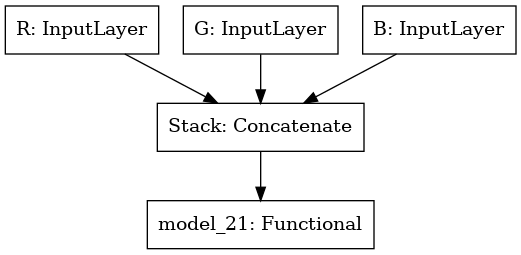

In [63]:
def get_model(dataset: tf.data.TFRecordDataset, input_layers: Dict[str, tf.keras.Input], classifications: Dict[str, str]) -> tf.keras.Model:
    # Adapt the Normalization layer with the training dataset.
    normalization = tf.keras.layers.Normalization(name="Normalize")
    normalization.adapt(
        dataset.map(
            lambda inputs, _: tf.stack([inputs[name] for name in input_bands], axis=-1)
        )
    )

    # Define the Fully Convolutional Network.
    fcn_model = tf.keras.Sequential([
        tf.keras.Input(shape=(None, None, len(input_layers)), name="Inputs"),
        normalization,
        tf.keras.layers.Conv2D(filters=32, kernel_size=5, activation="relu", name="Conv2D"),
        tf.keras.layers.Conv2DTranspose(filters=16, kernel_size=5, activation="relu", name="Deconv2D"),
        tf.keras.layers.Dense(len(classifications), activation="softmax", name="LandCover"),
    ], name="FullyConvolutionalNetwork")
    
    fcn_model.summary()
    tf.keras.utils.plot_model(fcn_model, show_shapes=True)

    return fcn_model

from tensorflow.keras import layers

def get_model_unet(dataset: tf.data.TFRecordDataset, input_layers: Dict[str, tf.keras.Input], classifications: Dict[str, str]) -> tf.keras.Model:
    inputs = tf.keras.Input(shape=(None, None, len(input_layers)), name="Inputs")

    ### [First half of the network: downsampling inputs] ###

    # Entry block
    x = layers.Conv2D(32, 3, strides=2, padding="same")(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    # Blocks 1, 2, 3 are identical apart from the feature depth.
    for filters in [64, 128, 256]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(filters, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    ### [Second half of the network: upsampling inputs] ###

    for filters in [256, 128, 64, 32]:
        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.UpSampling2D(2)(x)

        # Project residual
        residual = layers.UpSampling2D(2)(previous_block_activation)
        residual = layers.Conv2D(filters, 1, padding="same")(residual)
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    # Add a per-pixel classification layer
    outputs = layers.Conv2D(len(classifications), 3, activation="softmax", padding="same")(x)

    # Define the model
    return tf.keras.Model(inputs, outputs)
    # model = model(inputs)
    # return model

    # return inner_model

# Define the input dictionary layers.
input_layers = {
    name: tf.keras.Input(shape=(None, None, 1), name=name)
    for name in INPUT_BANDS
}

inner_model = get_model_unet(dataset=training_dataset, input_layers=input_layers, classifications=CLASSIFICATIONS)

# Model wrapper that takes an input dictionary and feeds it to the FCN.
inputs_stack = tf.keras.layers.concatenate(input_layers.values(), name="Stack")

model = tf.keras.Model(input_layers, inner_model(inputs_stack))

tf.keras.utils.plot_model(model)

In [64]:
def soft_dice_loss(y_true, y_pred, epsilon=1e-6): 
    ''' 
    Soft dice loss calculation for arbitrary batch size, number of classes, and number of spatial dimensions.
    Assumes the `channels_last` format.
  
    # Arguments
        y_true: b x X x Y( x Z...) x c One hot encoding of ground truth
        y_pred: b x X x Y( x Z...) x c Network output, must sum to 1 over c channel (such as after softmax) 
        epsilon: Used for numerical stability to avoid divide by zero errors
    
    # References
        V-Net: Fully Convolutional Neural Networks for Volumetric Medical Image Segmentation 
        https://arxiv.org/abs/1606.04797
        More details on Dice loss formulation 
        https://mediatum.ub.tum.de/doc/1395260/1395260.pdf (page 72)
        
        Adapted from https://github.com/Lasagne/Recipes/issues/99#issuecomment-347775022
    '''
    
    # skip the batch and class axis for calculating Dice score
    axes = tuple(range(1, len(y_pred.shape)-1)) 
    numerator = 2. * np.sum(y_pred * y_true, axes)
    denominator = np.sum(np.square(y_pred) + np.square(y_true), axes)
    
    return 1 - np.mean((numerator + epsilon) / (denominator + epsilon)) # average over classes and batch
    # thanks @mfernezir for catching a bug in an earlier version of this implementation!

In [65]:
import keras.backend as K

def DiceBCELoss(targets, inputs, smooth=1e-6):
    #flatten label and prediction tensors
    inputs = K.flatten(inputs)
    targets = K.flatten(targets)
    
    BCE = K.binary_crossentropy(targets, inputs)
    intersection = K.sum(K.dot(targets, inputs))
    dice_loss = 1 - (2*intersection + smooth) / (K.sum(targets) + K.sum(inputs) + smooth)
    Dice_BCE = BCE + dice_loss
    
    return Dice_BCE

In [66]:
model.compile(
    optimizer="adam",
    loss="categorical_crossentropy",
    # loss=DiceBCELoss,
    metrics=["accuracy", tf.keras.metrics.MeanIoU(num_classes=NUM_CLASSES)],
)

# https://lars76.github.io/2018/09/27/loss-functions-for-segmentation.html
# https://www.kaggle.com/code/bigironsphere/loss-function-library-keras-pytorch/notebook#Usage-Tips
# https://www.jeremyjordan.me/semantic-segmentation/#loss

In [ ]:
# Train the model.
history = model.fit(
    training_dataset.shuffle(10),
    validation_data=testing_dataset,
    epochs=15,
)

# Save it as files.
model.save("model-unet")

Epoch 1/15
     84/Unknown - 114s 1s/step - loss: 2.8445 - accuracy: 0.4596 - mean_io_u_4: 0.4035

In [ ]:
history.history["mean_io_u_8"]

In [ ]:
import tensorflow as tf

model = tf.keras.models.load_model("model-mean-iou")

tf.keras.utils.plot_model(model)

In [ ]:
from typing import List

def render_classifications(values: np.ndarray, palette: List[str]) -> np.ndarray:
  # Create a color map from a hex color palette.
  xs = np.linspace(0, len(palette), 256)
  indices = np.arange(len(palette))
  color_map = np.array([
        np.interp(xs, indices, [int(c[0:2], 16) for c in palette]),  # red
        np.interp(xs, indices, [int(c[2:4], 16) for c in palette]),  # green
        np.interp(xs, indices, [int(c[4:6], 16) for c in palette]),  # blue
  ]).astype(np.uint8).transpose()

  color_indices = (values / len(palette) * 255).astype(np.uint8)
  return np.take(color_map, color_indices, axis=0)

def render_landcover(patch: np.ndarray) -> np.ndarray:
  return render_classifications(patch, list(CLASSIFICATIONS.values()))

In [ ]:
def display_legend():
  reset_color = "\u001b[0m"
  colored = lambda red, green, blue: f"\033[48;2;{red};{green};{blue}m"
  for name, color in CLASSIFICATIONS.items():
    red   = int(color[0:2], 16)
    green = int(color[2:4], 16)
    blue  = int(color[4:6], 16)
    print(f"{colored(red, green, blue)}   {reset_color} {name}")

In [ ]:
batches = list(testing_dataset.take(10).as_numpy_iterator())
patches, masks = batches[0]

In [ ]:
import matplotlib.pyplot as plt

figsize = [12, 12]     # figure size, inches

def predict_and_compare(patch_batch: Dict[str, np.ndarray], mask_batch: Dict[str, np.ndarray]):
    # fig.add_subplot(len(patch_batch), 3, i)
    batch_size = 3 # len(patch_batch['R'])
    fig, ax = plt.subplots(nrows=batch_size, ncols=3, figsize=figsize, dpi=100)
    fig.tight_layout()
    display_legend()
        
    ax[0, 0].set_title('Image (RGB)')
    ax[0, 1].set_title('Actual mask')
    ax[0, 2].set_title('Predicted mask')
        
    for patch_index in range(batch_size):
        prediction = model.predict(patch_batch)[patch_index]
        outputs = np.argmax(prediction, axis=-1).astype(np.uint8)
        # print(f"outputs: {outputs.dtype} {outputs.shape}")
        
        # Plot image
        image = (np.stack([patches['R'][patch_index], patches['G'][patch_index], patches['B'][patch_index]], axis=2)*255).astype(np.uint8)
        ax[patch_index, 0].imshow(image)
            
        # Plot actual masks
        mask = np.argmax(masks[patch_index, :, :, :], axis=-1).astype(np.uint8)
        ax[patch_index, 1].imshow(render_landcover(mask))
                    
        # Plot predictions
        ax[patch_index, 2].imshow(render_landcover(outputs))

In [ ]:
predict_and_compare(patch_batch=patches, mask_batch=masks)

In [ ]:
mask_distributions = []

for _, mask_batch in testing_dataset.take(10).as_numpy_iterator():
    for batch_index in range(0, len(mask_batch)):
        mask_distributions.append({key: mask_batch[batch_index, :, :, classification_index].sum()/(512*512) for classification_index, key in enumerate(CLASSIFICATIONS.keys())})

In [ ]:
list(enumerate(mask_distributions))